In [6]:
# Import necessary modules
from duckduckgo_search import ddg_images  # Module for searching images online
from fastcore.all import *  # Fastcore library for utility functions used to simplify and enhance the productivity of working with data, e.g.,'L','download_url','path','sleep'
from fastdownload import download_url  # Function for downloading files
from fastai.vision.all import *  # Fastai library for computer vision tasks

In [47]:
# function to search image online
def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
# Define the search terms and path
searches = 'elliptical','spiral'
path = Path('copy the project folder path in the drive') # for example '/content/drive/MyDrive/project'

In [48]:
# Iterate over the search terms and download images
# it will also save the images inside respective folders
from time import sleep
for o in searches:
    dest = (path/'elliptical_or_spiral'/o)
    dest.mkdir(exist_ok=True, parents=True)
    # Download images based on the search term
    download_images(dest, urls=search_images(f'{o} galaxy photo'))
    # Pause between searches to avoid over-loading server
    sleep(10)
    # Resize the downloaded images
    resize_images(path/'elliptical_or_spiral'/o, max_size=400, dest=path/'elliptical_or_spiral'/o)

Searching for 'elliptical galaxy photo'
Searching for 'spiral galaxy photo'


#### Train the model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [49]:
# Verify and remove any failed images
failed = verify_images(get_image_files(path/'elliptical_or_spiral'))
failed.map(Path.unlink)
len(failed)

6

In [50]:
# Create dataloaders from the image dataset (prepare image dataset for training)
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=16)

In [51]:
# Create a vision learner and fine-tune the model
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.997646,0.124767,0.030303,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.263737,0.022823,0.000000,00:49
1,0.208702,0.033147,0.000000,00:52
2,0.150991,0.016744,0.000000,00:49
3,0.119990,0.014176,0.000000,00:50
4,0.095751,0.005059,0.000000,00:50
5,0.095309,0.006127,0.000000,00:49
6,0.085680,0.014012,0.000000,00:51
7,0.070300,0.013297,0.000000,00:49
8,0.082634,0.020648,0.000000,00:51
9,0.071168,0.027796,0.030303,00:49


### Testing the model

Searching for 'elliptical galaxy photos'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


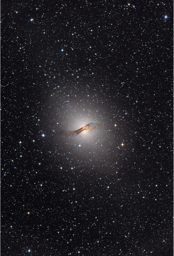

In [52]:
# download random image (taking random picture by specifying the index number)
# 1. Elliptical galaxy
download_url(search_images('elliptical galaxy photos')[57], f'{path}/elliptical.jpg', show_progress=False)
Image.open(f'{path}/elliptical.jpg').to_thumb(256,256)

Searching for 'spiral galaxy photos'


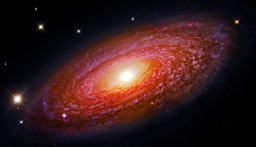

In [53]:
# 2. spiral galaxy
download_url(search_images('spiral galaxy photos')[57], f'{path}/spiral.jpg', show_progress=False)
Image.open(f'{path}/spiral.jpg').to_thumb(256,256)

In [57]:
# Use our model (and build your own!)
is_elliptical,_,probs = learn.predict(PILImage.create(f'{path}/spiral.jpg'))
print(f"This is a: {is_elliptical}.")
if probs[0]>0.5:
      print(f"Probability it's a elliptical: {probs[0]:.4f}")
elif probs[0]<0.5:
    print(f"Probability it's a spiral: {probs[1]:.4f}")
print(probs)

This is a: spiral.
Probability it's a spiral: 1.0000
tensor([1.4327e-06, 1.0000e+00])


Our model can predict spiral and elliptical galaxies with 99.999999% accuracy.

___________________________________________________________________________________________________________________________________________________________________